In [2]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/32/a6/4321f0f30ee11d6d85f49251d417f4e885fe7638b5ac50b7e3c80cccf141/opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl.metadata
Using cached opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl (33.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

In [3]:
df = pd.read_csv("/Users/saqlainnaseemkalokhe/Desktop/Honors/Dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


Extracting Cataract & Normal information from the Dataset

In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


Normal Images

In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
print(len(cataract),len(normal))

594 500


Creating Dataset from images

In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/Users/saqlainnaseemkalokhe/Desktop/Honors/Dataset/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(cataract,1)

 24%|█████████▋                              | 143/594 [00:00<00:00, 741.00it/s][ WARN:0@13.788] global loadsave.cpp:248 findDecoder imread_('/Users/saqlainnaseemkalokhe/Desktop/Honors/Dataset/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@13.792] global loadsave.cpp:248 findDecoder imread_('/Users/saqlainnaseemkalokhe/Desktop/Honors/Dataset/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
100%|████████████████████████████████████████| 594/594 [00:00<00:00, 907.07it/s]


In [14]:
len(dataset)

588

In [15]:
dataset = create_dataset(normal,0)

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 652.95it/s]


In [16]:
len(dataset)

1088

Let's see some images

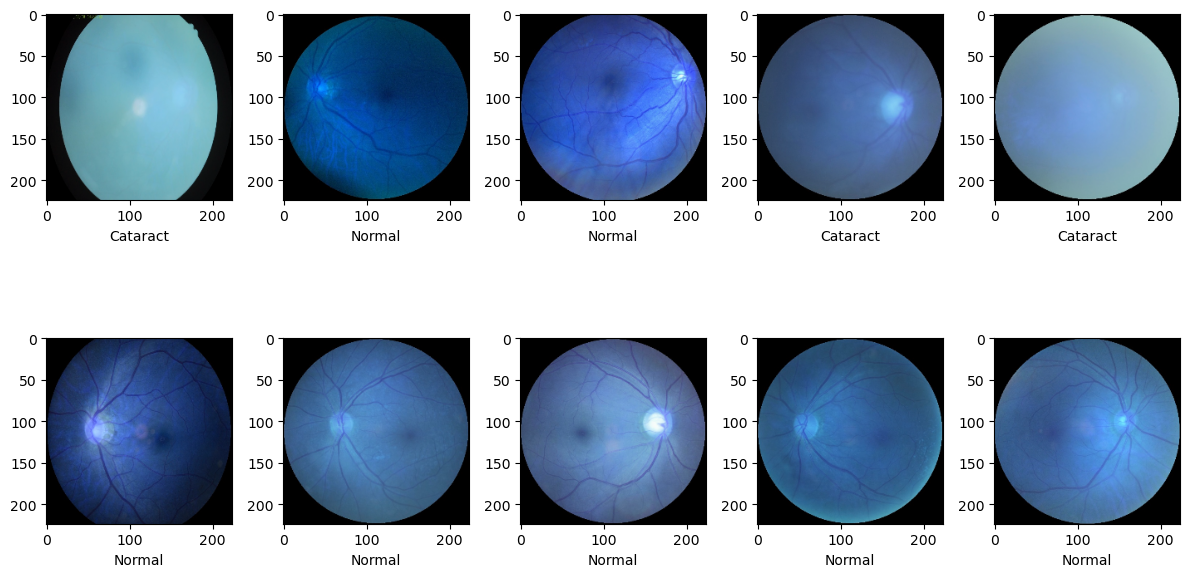

In [21]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

Dividing dataset into x(features) & y(target)

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

Creating Model

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [20]:
for layer in vgg.layers:
    layer.trainable = False

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [31]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 134s 5s/step - loss: 0.8032 - accuracy: 0.9080 - val_loss: 1.2751 - val_accuracy: 0.8807
Epoch 2/15
28/28 [==============================] - 151s 5s/step - loss: 0.5249 - accuracy: 0.9460 - val_loss: 0.9721 - val_accuracy: 0.9541
Epoch 3/15
28/28 [==============================] - 154s 6s/step - loss: 0.1785 - accuracy: 0.9782 - val_loss: 1.0610 - val_accuracy: 0.9541
Epoch 4/15
11/28 [==========>...................] - ETA: 1:18 - loss: 0.0489 - accuracy: 0.9886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 156s 6s/step - loss: 0.1792 - accuracy: 0.9782 - val_loss: 0.8448 - val_accuracy: 0.9633
Epoch 5/15
28/28 [==============================] - 157s 6s/step - loss: 0.0157 - accuracy: 0.9943 - val_loss: 0.7913 - val_accuracy: 0.9633
Epoch 6/15
28/28 [==============================] - 159s 6s/step - loss: 4.3823e-04 - accuracy: 1.0000 - val_loss: 0.8026 - val_accuracy: 0.9633
Epoch 7/15
22/28 [======================>.......] - ETA: 28s - loss: 7.4909e-05 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 160s 6s/step - loss: 6.1831e-05 - accuracy: 1.0000 - val_loss: 0.8174 - val_accuracy: 0.9633
Epoch 8/15
28/28 [==============================] - 162s 6s/step - loss: 3.8318e-05 - accuracy: 1.0000 - val_loss: 0.8091 - val_accuracy: 0.9633
Epoch 9/15
12/28 [===========>..................] - ETA: 1:17 - loss: 7.5207e-06 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 161s 6s/step - loss: 3.0206e-05 - accuracy: 1.0000 - val_loss: 0.8008 - val_accuracy: 0.9633
Epoch 10/15
28/28 [==============================] - 165s 6s/step - loss: 2.5902e-05 - accuracy: 1.0000 - val_loss: 0.8006 - val_accuracy: 0.9633
Epoch 11/15
 2/28 [=>............................] - ETA: 2:00 - loss: 2.0599e-06 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 160s 6s/step - loss: 2.3699e-05 - accuracy: 1.0000 - val_loss: 0.8004 - val_accuracy: 0.9633
Epoch 12/15
22/28 [======================>.......] - ETA: 27s - loss: 2.5427e-05 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 159s 6s/step - loss: 2.1842e-05 - accuracy: 1.0000 - val_loss: 0.7998 - val_accuracy: 0.9633
Epoch 13/15
28/28 [==============================] - 166s 6s/step - loss: 1.9992e-05 - accuracy: 1.0000 - val_loss: 0.8008 - val_accuracy: 0.9633
Epoch 14/15
12/28 [===========>..................] - ETA: 1:18 - loss: 2.5766e-05 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


28/28 [==============================] - 162s 6s/step - loss: 1.8586e-05 - accuracy: 1.0000 - val_loss: 0.8027 - val_accuracy: 0.9633
Epoch 15/15
28/28 [==============================] - 161s 6s/step - loss: 1.7526e-05 - accuracy: 1.0000 - val_loss: 0.8043 - val_accuracy: 0.9633


In [32]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 26s 4s/step - loss: 0.8043 - accuracy: 0.9633
loss: 0.8042874336242676
Accuracy: 0.963302731513977


In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)

7/7 [==============================] - 25s 4s/step


In [35]:
model.save("eyedisease.h5")

/Users/saqlainnaseemkalokhe/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1 labels
accuracy = accuracy_score(y_test, y_pred_labels)

In [26]:
from keras.models import load_model

loaded_model = load_model("eyedisease.h5")

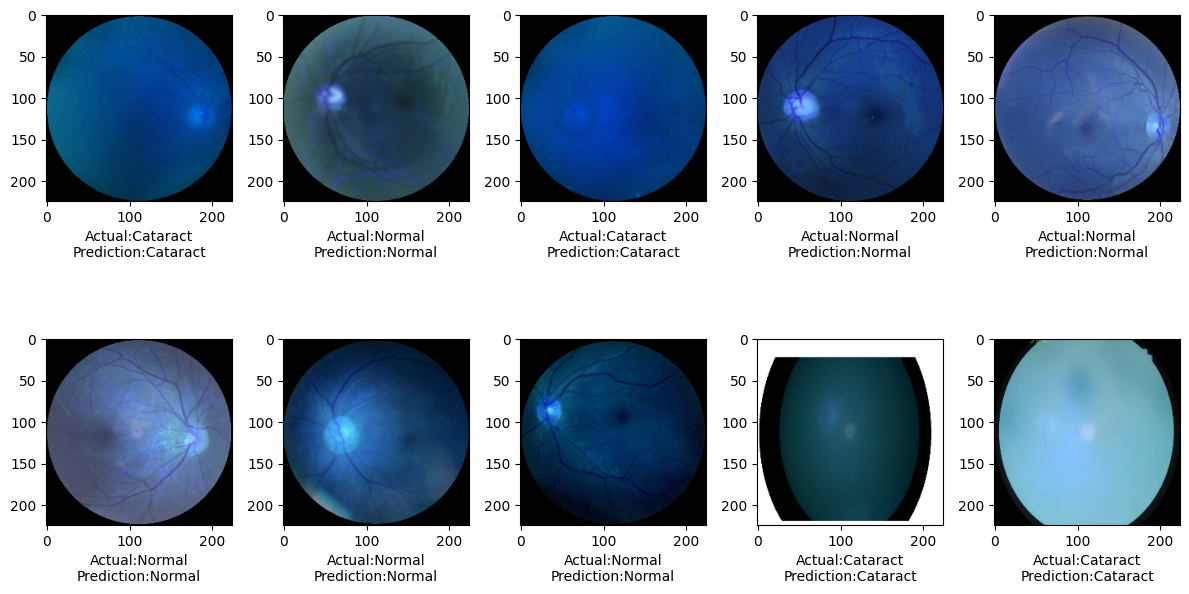

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    
    # Convert the image to the shape expected by your model
    image = np.expand_dims(image, axis=0)
    
    # Make a prediction using the loaded model
    prediction = loaded_model(image)  # Modify this line based on how your model accepts input
    
    # Convert the prediction to a category (assuming binary classification)
    pred_category = 1 if prediction > 0.5 else 0

    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image[0])  # Since we added an extra dimension for batch size, we need to remove it
    plt.xlabel("Actual:{}\nPrediction:{}".format(label, pred_label))

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 192ms/step


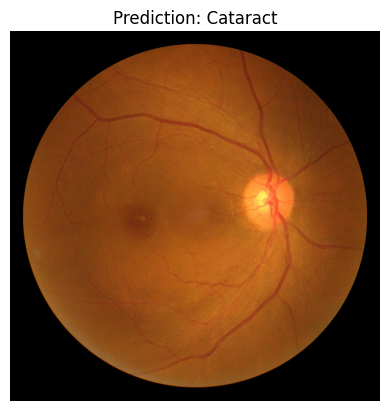

In [28]:
import numpy as np
import cv2  
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Resize the image to the size expected by your model (e.g., 224x224)
    image = cv2.resize(image, (224, 224))
    
    # Preprocess the image (normalize and convert to a numpy array)
    image = img_to_array(image) / 255.0
    
    # Expand the dimensions to match the model's input shape (batch size of 1)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to make predictions using the loaded model
def predict_image(image_path, model):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    
    # Make a prediction using the loaded model
    prediction = model.predict(image)
    
    # Assuming binary classification (0 or 1)
    if prediction > 0.5:
        prediction_label = "Cataract"
    else:
        prediction_label = "Normal"
    
    return prediction_label

# Path to the image you want to predict
image_path = '/Users/saqlainnaseemkalokhe/Desktop/Honors/937_right.jpg'  

# Make a prediction using the loaded model
predicted_label = predict_image(image_path, loaded_model)

# Display the image and the prediction
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()
